# IRSwaps in `rvcore`

1. Data Source Configuration
2. Data Fetching
3. Pricing
4. MTM PnL 
5. Backtesting

In [26]:
import sys
sys.path.append("../")

import os
from dotenv import dotenv_values
env_path = os.path.join(os.getcwd(), "../.env")
config = dotenv_values(env_path)

In [25]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import QuantLib as ql
from datetime import datetime

from core.IRSwaps import IRSwaps, IRSwapQuery, IRSwapValue, IRSwapStructure, IRSwapStructureFunctionMap, IRSwapValueFunctionMap
from core.DataFetching.FixingsFetcher import FixingsFetcher
from core.utils.ql_utils import ql_date_to_datetime

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.dates as mdates
plt.style.use('ggplot')
params = {'legend.fontsize': 'x-large',
        'figure.figsize': (12, 8),
        'axes.labelsize': 'x-large',
        'axes.titlesize':'x-large',
        'xtick.labelsize':'x-large',
        'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

import nest_asyncio
nest_asyncio.apply()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Source Configuration:
- CSV ingest of Par Swap Rates with 'Date' column in ISO 8601 extended format with timezone offset (UTC)
- 'Fetcher' class (using CME's + Eris FTP as an example)
- `curve` are CME Clearing Conventions
- `fixings` is an optional arg; its just a `Dict[datetime, float]`
	- `FixingsFetcher` is useful for fetching fixing from NYFRB or FRED

In [ ]:
curve = "USD-SOFR-1D"
data_source = r"CSV_C:\Users\chris\Project Bond King\rvcore\data\usd_ois.csv"

# fred_api_key is optional; by default will fetch from NYFRB for SOFR but site is down on Fridays
ff = FixingsFetcher(fred_api_key=config["FRED_API_KEY"]) 
fixings = ff.get_fixings("USD-SOFR-1D")

In [32]:
usd_ois = IRSwaps(
    curve=curve,
    data_source=data_source,
    fixings=fixings,
    ql_interpolation_algo="log_linear",
    pre_fetch_curves=True,
    error_verbose=True,
    max_njobs=-1,
)

BOOTSTRAPPING HISTORICAL IRSWAPS CURVE...: 100%|██████████| 248/248 [00:12<00:00, 20.56it/s]
BOOTSTRAPPING INTRADAY IRSWAPS CURVE...: 0it [00:00, ?it/s]


## Data Fetching:

### Term Structure

In [5]:
usd_ois.irswaps_term_structure_plotter(bdates=[datetime(2025, 3, 31), datetime(2025, 5, 9)], fwd_tenors=["0D", "1Y"], use_plotly=True)

PRICING IRSWAPS...: 100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


### Data Grids

In [6]:
dt = datetime(2025, 5, 2)

fwds = ["0D", "1M", "3M", "6M", "9M", "1Y", "2Y", "3Y", "5Y"]
underlyings = ["1Y", "2Y", "3Y", "4Y", "5Y", "6Y", "7Y", "8Y", "9Y", "10Y", "12Y", "15Y", "20Y", "30Y"]

usd_ois.irswaps_data_grid_builder(bdates=[dt], fwd_tenors=fwds, irswap_tenors=underlyings, to_pydt=True)[dt]

PRICING IRSWAPS...: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


tenor,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y,12Y,15Y,20Y,30Y
forward,,,,,,,,,,,,,,
0D,3.917953,3.597766,3.522232,3.522009,3.551255,3.601102,3.653882,3.701582,3.747296,3.788116,3.859231,3.939622,3.992933,3.906902
1M,3.823928,3.552117,3.495636,3.504844,3.540535,3.593723,3.648453,3.697412,3.743675,3.785439,3.857584,3.937390,3.989865,3.902721
3M,3.656462,3.468297,3.447342,3.474176,3.521762,3.581197,3.638944,3.691031,3.738625,3.781686,3.854797,3.933995,3.984517,3.895227
6M,3.450907,3.377670,3.398525,3.446450,3.508495,3.575022,3.636350,3.690637,3.739591,3.784228,3.858001,3.934882,3.981408,3.887619
9M,3.325604,3.330701,3.379448,3.441311,3.513585,3.584426,3.646786,3.702342,3.751660,3.796814,3.870123,3.943137,3.984348,3.884930
1Y,3.266913,3.315178,3.381219,3.451637,3.530990,3.604306,3.666109,3.722365,3.770929,3.815958,3.887349,3.956135,3.991311,3.885402
2Y,3.364688,3.441191,3.517524,3.602950,3.679215,3.741390,3.797358,3.844983,3.889066,3.924188,3.985335,4.031729,4.037643,3.900777
3Y,3.521893,3.599925,3.689824,3.767137,3.826923,3.880118,3.925465,3.967553,4.000084,4.031600,4.078143,4.102684,4.079365,3.911193
5Y,3.879487,3.945831,3.992539,4.037315,4.074369,4.110401,4.136079,4.162353,4.182724,4.199093,4.204383,4.209709,4.132066,3.904364


### Timeseries

In [12]:
spot2y_query = IRSwapQuery(tenor="2Y", structure=IRSwapStructure.OUTRIGHT)
spot5y_query = IRSwapQuery(tenor="5Y", structure=IRSwapStructure.OUTRIGHT)
spot10y_query = IRSwapQuery(tenor="10Y", structure=IRSwapStructure.OUTRIGHT)

spot2s10s_query = spot10y_query - spot2y_query 
spot2s5s10s_query = 2 * spot5y_query - spot2y_query - spot10y_query

ts_df = usd_ois.irswaps_timeseries_builder(
    start_date=datetime(2024, 1, 1),
    end_date=datetime(2025, 5, 2),
    queries=[spot2y_query, spot5y_query, spot10y_query, (spot2s10s_query, "2s10s"), (spot2s5s10s_query, "2s5s10s")],
    n_jobs=-1,
)

ts_df

PRICING IRSWAPS...: 100%|██████████| 2000/2000 [00:03<00:00, 509.19it/s]


,2s10s,2s5s10s,USD-SOFR-1D 5Y OUTRIGHT RATE,USD-SOFR-1D 10Y OUTRIGHT RATE,USD-SOFR-1D 2Y OUTRIGHT RATE
Date,,,,,
2024-01-02 17:00:00-05:00,-0.615174,-0.475575,3.600154,3.530354,4.145529
2024-01-03 17:00:00-05:00,-0.645827,-0.498961,3.578953,3.505520,4.151347
2024-01-04 17:00:00-05:00,-0.615592,-0.465840,3.674201,3.599325,4.214917
2024-01-05 17:00:00-05:00,-0.579288,-0.455959,3.704785,3.643121,4.222409
2024-01-08 17:00:00-05:00,-0.564067,-0.459570,3.682089,3.629841,4.193908
...,...,...,...,...,...
2025-04-28 17:00:00-04:00,0.246544,-0.257104,3.447425,3.699249,3.452705
2025-04-29 17:00:00-04:00,0.241253,-0.264023,3.402999,3.655636,3.414384
2025-04-30 17:00:00-04:00,0.268116,-0.272733,3.375515,3.645940,3.377823


In [13]:
usd_ois.timeseries_df_plotter(
    df=ts_df, cols_to_plot=[spot2y_query.col_name(), spot5y_query.col_name(), spot10y_query.col_name()], cols_to_plot_raxis=["2s10s", "2s5s10s"], use_plotly=True
)

## Pricing
- May 9th 2025 USD-SOFR-1D curve

In [5]:
dt = datetime(2025, 5, 9)
ql_curve = usd_ois.fetch_ql_irswap_curves(bdates=[dt], to_pydt=True)[dt]

curve_handle = ql.YieldTermStructureHandle(ql_curve)
ql.Settings.instance().evaluationDate = curve_handle.referenceDate() 
ql_curve

<QuantLib.QuantLib.DiscountCurve; proxy of <Swig Object of type 'ext::shared_ptr< InterpolatedDiscountCurve< LogLinear > > *' at 0x000002067F6F3060> >

### Outright Rec 100k/bp in spot 10s

In [6]:
q = IRSwapQuery(tenor="10Y", structure=IRSwapStructure.OUTRIGHT, structure_kwargs={"bpv": 100_000})
package, risk_weights = IRSwapStructureFunctionMap(curve=curve, curve_handle=curve_handle).apply(structure=q.structure, tenor=q.tenor, **q.structure_kwargs)

outright: ql.OvernightIndexedSwap = package[0]

print("Eff/Mat Dates ", outright.startDate(), outright.maturityDate())
print("Par Rate: ", outright.fairRate() * 100)
print("Notional: ", outright.nominal())
print("NPV: ", outright.NPV())
print("BPV: ", outright.fixedLegBPS())

Eff/Mat Dates  May 13th, 2025 May 14th, 2035
Par Rate:  3.846811344618567
Notional:  120288085.03805847
NPV:  2.9802322387695312e-08
BPV:  100000.0


### Pay 50k/bp in 3M Fwd 5s30s

In [9]:
q = IRSwapQuery(tenor="10Y", structure=IRSwapStructure.CURVE, structure_kwargs={"front_tenor": "3Mx5Y", "back_tenor": "3Mx30Y", "bpv": -50_000})
package, risk_weights = IRSwapStructureFunctionMap(curve=curve, curve_handle=curve_handle).apply(structure=q.structure, tenor=q.tenor, **q.structure_kwargs)
sv = IRSwapValueFunctionMap(package=package, risk_weights=risk_weights, curve=curve, curve_handle=curve_handle).apply(q.value)

print("Curve Level (bps)", sv)
print("Notionals ", [s.nominal() for s in package])
print("BPVs ", [s.fixedLegBPS() for s in package])
print("Risk Weights, ", risk_weights)

Curve Level (bps) 36.669606791765105
Notionals  [110779436.06515536, 28957217.445144374]
BPVs  [50000.0, -49999.99999999999]
Risk Weights,  [1.0, -1.0]


### Pay 100m Belly in 1Y Fwd 2s5s10s

In [ ]:
q = IRSwapQuery(structure=IRSwapStructure.FLY, structure_kwargs={"front_tenor": "1Yx2Y", "belly_tenor": "1Yx5Y", "back_tenor": "1Yx10Y", "belly_notional": 100_000_000})
package, risk_weights = IRSwapStructureFunctionMap(curve=curve, curve_handle=curve_handle).apply(structure=q.structure, tenor=q.tenor, **q.structure_kwargs)
sv = IRSwapValueFunctionMap(package=package, risk_weights=risk_weights, curve=curve, curve_handle=curve_handle).apply(q.value)

print("Fly Level (bps)", sv)
print("Notionals ", [s.nominal() for s in package])
print("BPVs ", [s.fixedLegBPS() for s in package])
print("Risk Weights, ", risk_weights)

Fly Level (bps) -5.755992106749527
Notionals  [118101930.68439032, 100000000.0, 27468484.705994897]
BPVs  [-21971.7189979113, 43943.43799582258, -21971.71899791129]
Risk Weights,  [-1.0, 2.0, -1.0]


## MtM PnL
- Outright Rec 100k/bp in 3Mx5Y on Mar 31, 2025 at 3.6531129248242507

In [16]:
dt = datetime(2025, 3, 31)
ql_curve = usd_ois.fetch_ql_irswap_curves(bdates=[dt], to_pydt=True)[dt]
curve_handle = ql.YieldTermStructureHandle(ql_curve)
ql.Settings.instance().evaluationDate = curve_handle.referenceDate() 

q = IRSwapQuery(tenor="3Mx5Y", structure=IRSwapStructure.OUTRIGHT, structure_kwargs={"bpv": 100_000})
package, risk_weights = IRSwapStructureFunctionMap(curve=curve, curve_handle=curve_handle).apply(structure=q.structure, tenor=q.tenor, **q.structure_kwargs)

march31_3Mx5Y: ql.OvernightIndexedSwap = package[0]
print("Eff/Mat Dates ", march31_3Mx5Y.startDate(), march31_3Mx5Y.maturityDate())
print("Par Rate: ", march31_3Mx5Y.fairRate() * 100)
print("NPV: ", march31_3Mx5Y.NPV())
print("Notional: ", march31_3Mx5Y.nominal())
print("BPV: ", march31_3Mx5Y.fixedLegBPS())

Eff/Mat Dates  July 2nd, 2025 July 2nd, 2030
Par Rate:  3.653167830067461
NPV:  2.2351741790771484e-08
Notional:  221996611.0350063
BPV:  100000.0


In [20]:
march31_3Mx5Y_query = IRSwapQuery(
    effective_date=ql_date_to_datetime(march31_3Mx5Y.startDate()),
    maturity_date=ql_date_to_datetime(march31_3Mx5Y.maturityDate()),
    structure=IRSwapStructure.OUTRIGHT,
    structure_kwargs={"fixed_rate": march31_3Mx5Y.fairRate() * 100, "bpv": march31_3Mx5Y.fixedLegBPS()},
    value=IRSwapValue.NPV
)

mtm_3Mx5Y_df = usd_ois.irswaps_timeseries_builder(start_date=datetime(2025, 3, 31), end_date=datetime(2025, 5, 9), queries=[march31_3Mx5Y_query], return_all=True)

PRICING IRSWAPS...: 100%|██████████| 29/29 [00:00<00:00, 94.43it/s]


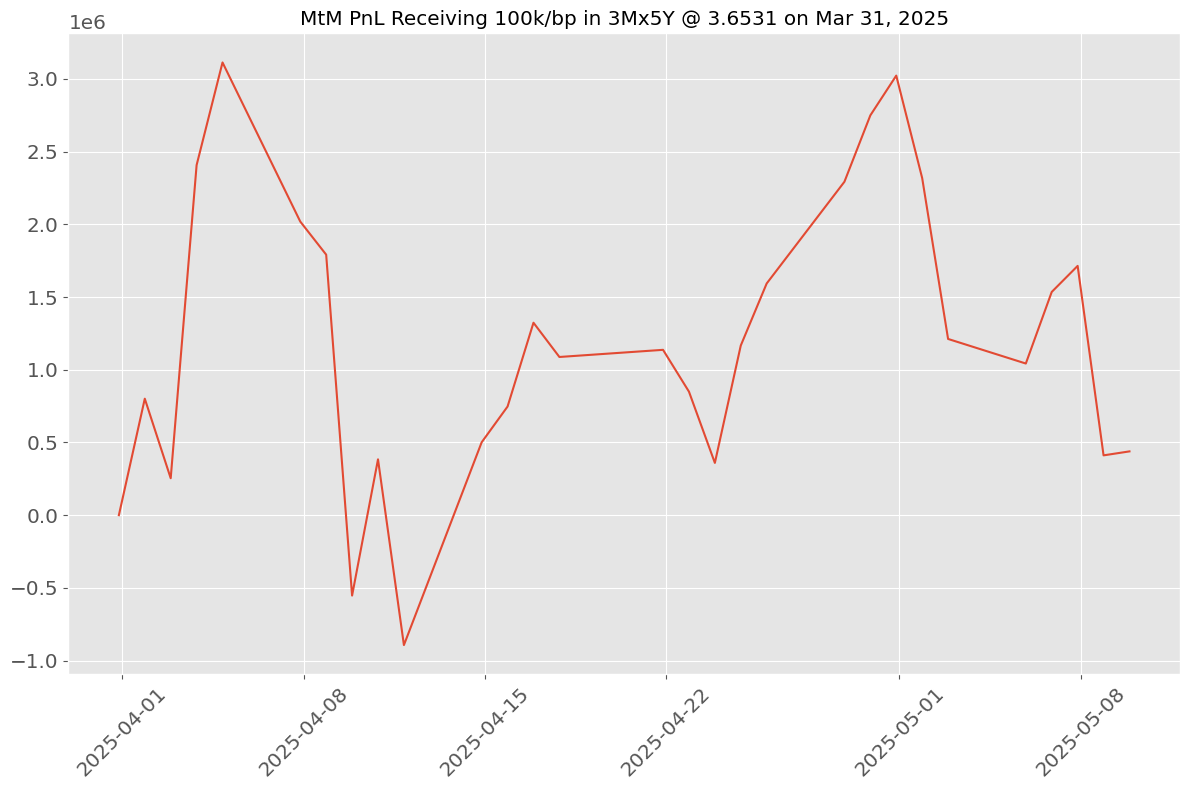

In [24]:
fig, ax = plt.subplots()
ax.plot(mtm_3Mx5Y_df.index, mtm_3Mx5Y_df)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

plt.title("MtM PnL Receiving 100k/bp in 3Mx5Y @ 3.6531 on Mar 31, 2025")
plt.xticks(rotation=45)  
plt.tight_layout()       
plt.show()